In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Fake news detection
LSTM model
"""

import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from collections import Counter
import os
import getEmbeddings
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

In [18]:
top_words = 5000
epoch_num = 5
batch_size = 64

In [19]:
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

# Read the text data
if not os.path.isfile('./xtr_shuffled.npy') or \
    not os.path.isfile('./xte_shuffled.npy') or \
    not os.path.isfile('./ytr_shuffled.npy') or \
    not os.path.isfile('./yte_shuffled.npy'):
    getEmbeddings.clean_data()


xtr = np.load('./xtr_shuffled.npy', allow_pickle=True)
xte = np.load('./xte_shuffled.npy', allow_pickle=True)
y_train = np.load('./ytr_shuffled.npy', allow_pickle=True)
y_test = np.load('./yte_shuffled.npy', allow_pickle=True)

cnt = Counter()
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  

# Storing most common words
most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1

# Encode the sentences
for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

y_train = list(y_train)
y_test = list(y_test)

# Delete the short news
i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

# Generating test data
x_test = []
for x in xte:
    x_test.append(x.split())


In [20]:
# Encode the sentences
for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

# Truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160064    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 213,365
Trainable params: 213,365
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
251/251 [==============================] - 188s 726ms/step - loss: 0.4542 - accuracy: 0.7676 - val_loss: 0.2015 - val_accuracy: 0.9258
Epoch 2/5
251/251 [==============================] - 191s 758ms/step - loss: 0.1787 - accuracy: 0.9350 - val_loss: 0.1625 - val_accuracy: 0.9461
Epoch 3/5
251/251 [==============================] - 234s 935ms/step - loss: 0.0897

/Users/kimjoowhan/opt/anaconda3/envs/jh/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/kimjoowhan/opt/anaconda3/envs/jh/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


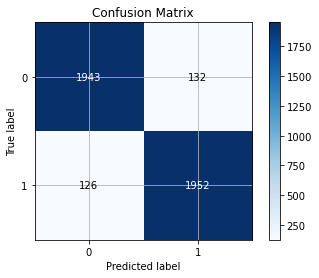

In [21]:
# Draw the confusion matrix
y_pred = model.predict_classes(X_test)
plot_cmat(y_test, y_pred)